In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")

In [2]:
import torch

from PycalcAct.dataset import Dataset
from PycalcAct.model import (
    MixedFCTemporalModel,
)
from PycalcAct.trainer import Trainer

_ = torch.manual_seed(1234)


In [3]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",  # Optional
    position_to_displacement=True,
    # Convert the x, y position to a single displacement value (sqrt((x(t+1)-x(t))^2 + (y(t+1)-y(t))^2)
)
model = MixedFCTemporalModel(
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
)

n_epochs = 750
trainer = Trainer(
    dataset, model, device="cuda"
)  # You can pass your own optimizer, criterion, learning rate, weight decay and learning rate scheduler.


In [4]:
trainer.summary(optimizer=False, model=True, data=True)

Model
Layer (type:depth-idx)                   Output Shape              Param #
MixedFCTemporalModel                     [10, 4]                   --
├─GRU: 1-1                               [10, 120, 64]             25,728
├─Sequential: 1-2                        [10, 64]                  --
│    └─Sequential: 2-1                   [10, 64]                  --
│    │    └─Linear: 3-1                  [10, 64]                  491,584
│    │    └─ReLU: 3-2                    [10, 64]                  --
│    │    └─Dropout1d: 3-3               [10, 64]                  --
│    └─Sequential: 2-2                   [10, 64]                  --
│    │    └─Linear: 3-4                  [10, 64]                  4,160
│    │    └─ReLU: 3-5                    [10, 64]                  --
│    │    └─Dropout1d: 3-6               [10, 64]                  --
├─Linear: 1-3                            [10, 4]                   260
Total params: 521,732
Trainable params: 521,732
Non-trainable para

,Total,N4,Q4,Q4H7,T4
Train,16084,6144,4790,2299,2851
Validation,4022,1536,1198,575,713
Test,5027,1920,1497,719,891
Total,25133,9600,7485,3593,4455


# Learning with Displacement encoding

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.39 │                     38.19 │
│             3             │                      1.37 │                     38.71 │
│             4             │                      1.35 │                     44.03 │
│             13            │                      1.28 │                     45.57 │
│             14            │                      1.29 │                     46.07 │
│             22            │                      1.26 │                     46.10 │
│             29            │                      1.26 │                     46.15 │
│             33            │                      1.26 │                     47.04 │
│             39            │                      1.2

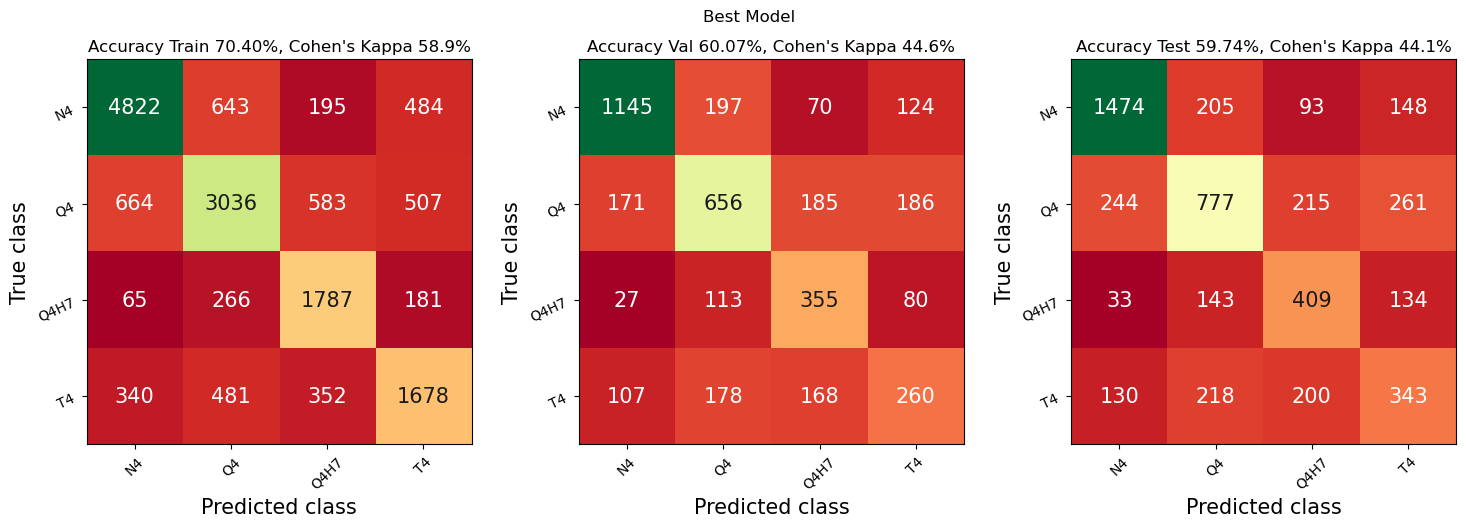

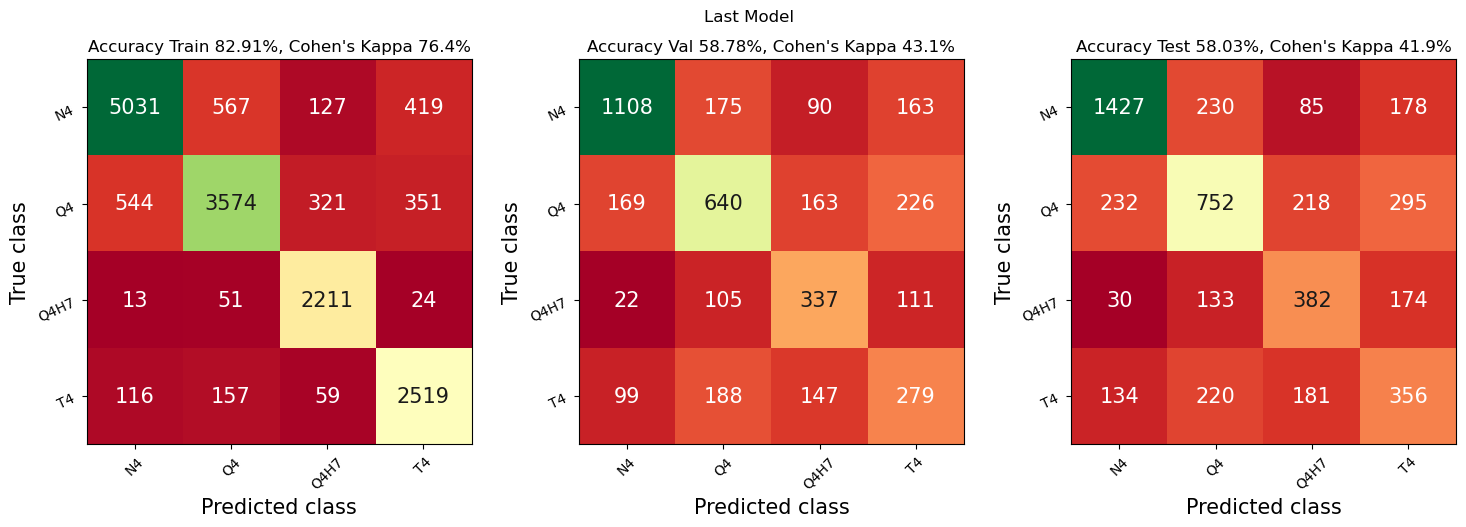

In [5]:
trainer.train(n_epochs)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model

# Learning without displacement encoding

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.39 │                     38.19 │
│             1             │                      1.39 │                     48.48 │
│             55            │                      1.26 │                     48.58 │
│             56            │                      1.26 │                     49.08 │
│             67            │                      1.25 │                     49.38 │
│             74            │                      1.25 │                     49.63 │
│             75            │                      1.24 │                     49.68 │
│             78            │                      1.24 │                     49.83 │
│             79            │                      1.2

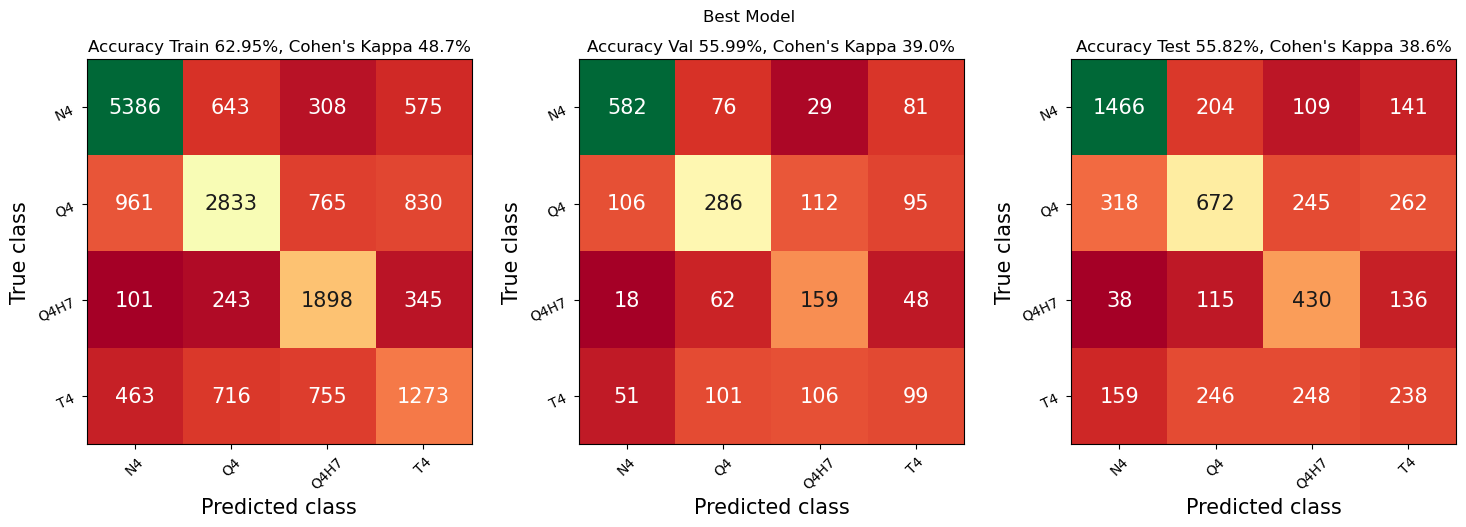

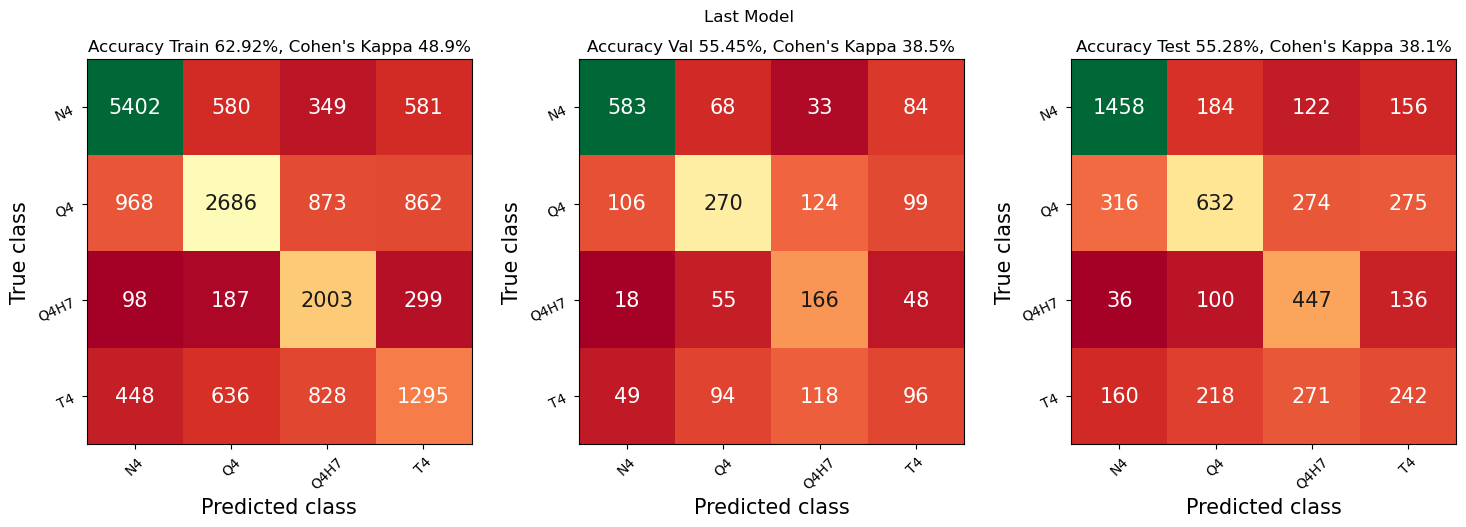

In [6]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path=None,
    test_size=0.2,
    val_size=0.1,
)
model = MixedFCTemporalModel(
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
)
trainer.reset(dataset, model)
trainer.train(n_epochs)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model

# Learning vastly overparametrized model and no regularization

In [7]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=4,
    n_rnn_layers=4,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=32,
    fc_hidden_size=256,
    dropout=0.0,
)
trainer.weight_decay = 0.0
trainer.reset(dataset=dataset, model=model)
trainer.train(n_epochs)

trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model


╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.39 │                     38.19 │
│             2             │                      1.38 │                     41.10 │
│             4             │                      1.34 │                     42.91 │
│             6             │                      1.29 │                     44.31 │
│             7             │                      1.25 │                     47.79 │
│             10            │                      1.24 │                     48.46 │
│             21            │                      1.18 │                     48.93 │
│             26            │                      1.17 │                     49.45 │
│             48            │                      1.1

# Same model with strong regularization
To regularize, we use dropout (randomly dropping some neurons with a probability p) and weight decay.

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.39 │                     38.19 │
│             1             │                      1.39 │                     39.93 │
│             3             │                      1.38 │                     42.07 │
│             6             │                      1.36 │                     45.00 │
│             9             │                      1.35 │                     45.35 │
│             17            │                      1.34 │                     46.32 │
│             21            │                      1.34 │                     47.39 │
│             54            │                      1.33 │                     48.18 │
│             61            │                      1.3

/home/clement/Documents/Projets/CalciumActivationClassification/src/PycalcAct/trainer.py:199: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/clement/Documents/Projets/CalciumActivationClassification/src/PycalcAct/trainer.py:199: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


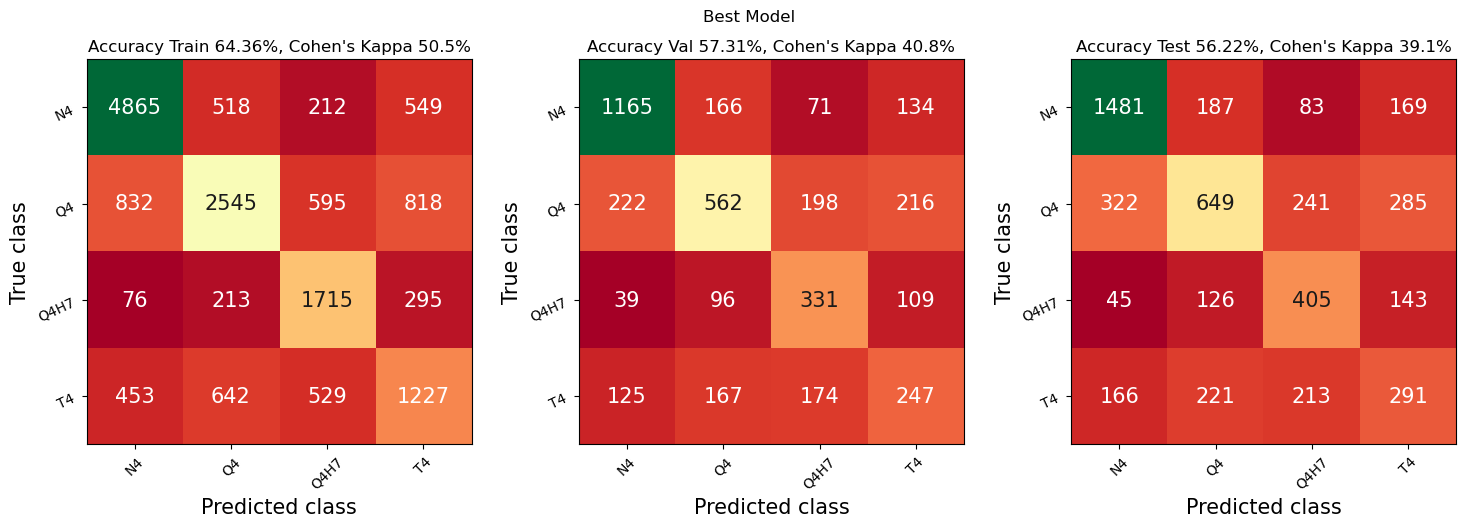

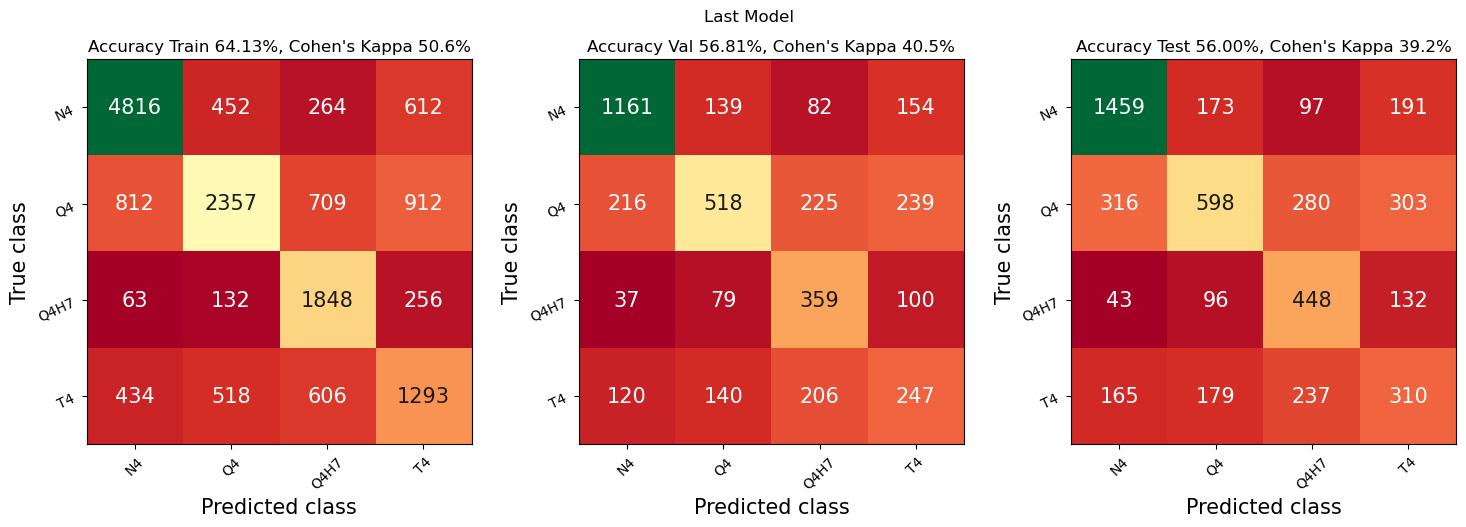

In [11]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=4,
    n_rnn_layers=4,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=32,
    fc_hidden_size=128,
    dropout=0.3,
)
trainer.weight_decay = 0.0005
trainer.reset(dataset=dataset, model=model)
trainer.train(n_epochs)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model


# Tiny model

╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.40 │                     14.62 │
│             10            │                      1.26 │                     40.25 │
│             20            │                      1.22 │                     46.37 │
│             30            │                      1.18 │                     47.69 │
│             40            │                      1.16 │                     49.20 │
│             50            │                      1.14 │                     49.68 │
│             60            │                      1.13 │                     50.85 │
│             70            │                      1.11 │                     52.39 │
│             80            │                      1.0

/home/clement/Documents/Projets/CalciumActivationClassification/src/PycalcAct/trainer.py:199: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/clement/Documents/Projets/CalciumActivationClassification/src/PycalcAct/trainer.py:199: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


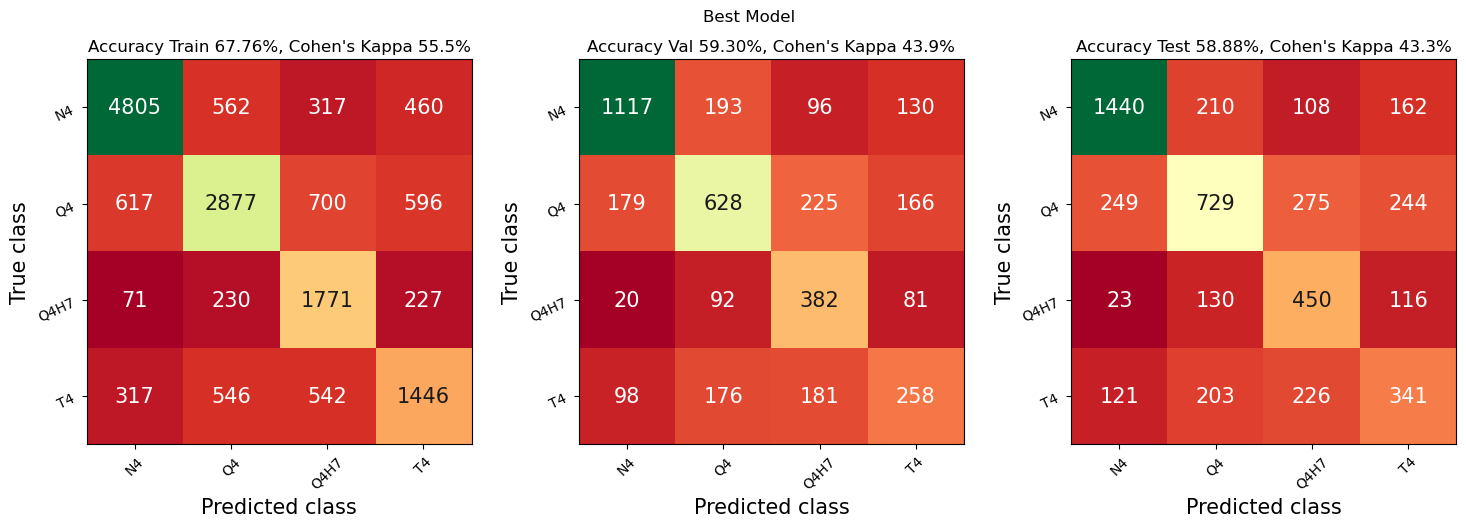

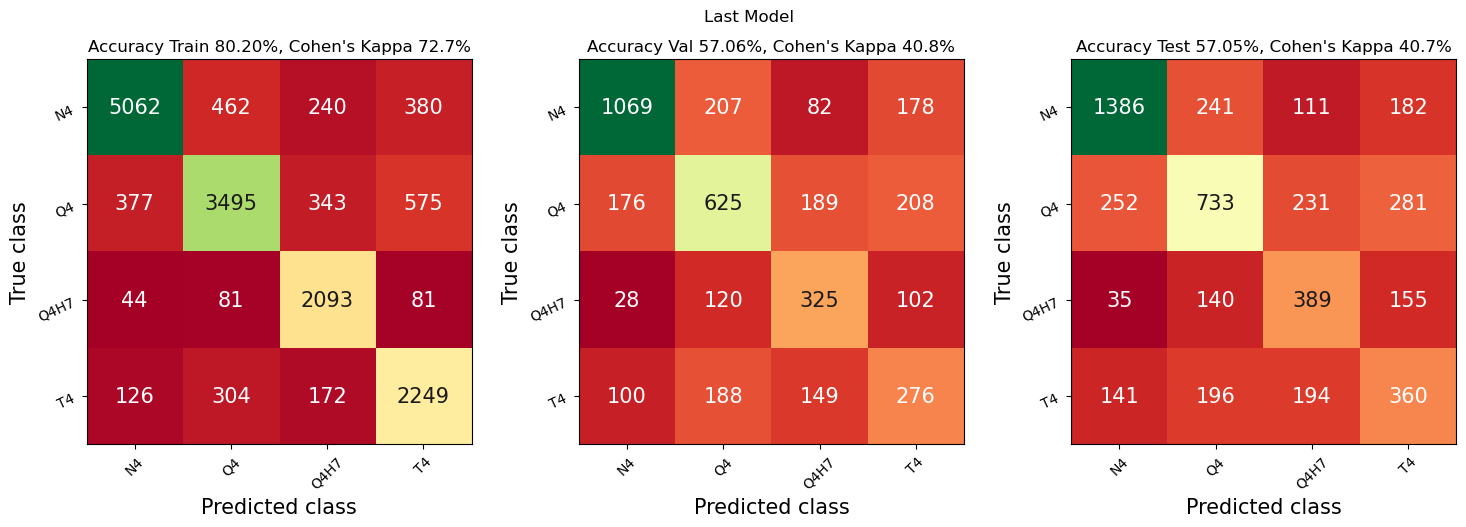

In [12]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=1,
    n_rnn_layers=1,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=16,
    fc_hidden_size=16,
    dropout=0,
    bidirectional=True,
    use_gru=True,
)
n_epochs = 2500  # We train for more epochs as it is a smaller model (thus faster).

trainer.reset(model=model)
trainer.train(n_epochs, val_every=10)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)

trainer.test("last")  # Testing on the last model
